Importing Libraries

In [11]:
import requests
from bs4 import BeautifulSoup
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from datetime import datetime
import pandas as pd
from selenium.webdriver.chrome.options import Options
from concurrent.futures import ThreadPoolExecutor
from skimage.feature import local_binary_pattern
import cv2
import numpy as np


In [13]:
url_dict ={
    "bellanaija": ["https://www.bellanaija.com/2025/11/lagos-fashion-week-2025-see-emmy-kasbits-collection/"]
    }

In [14]:
driver = webdriver.Chrome()

for web_page, urls in url_dict.items():
    folder = os.path.join('kasbit_images', web_page)
    if os.path.exists(folder):
        continue
    os.makedirs(folder, exist_ok=True)

    for url in urls:
        driver.get(url)
        time.sleep(15)

        elements = driver.find_elements(By.TAG_NAME, 'img')
        print(f"Found {len(elements)} image elements.")

        count = 0
        for index, img in enumerate(elements):
            src = img.get_attribute('src')
            if src and src.startswith("http"):
                try:
                    img_data = requests.get(src).content
                    filename = f"{'kasbit'}_{web_page}_{index+1}.jpg"
                    path = os.path.join(folder, filename)
                    with open((path), 'wb') as f:
                        f.write(img_data)
                except Exception as e:
                    print(f"Error downloading image {src}: {e}")
                    continue
        

driver.quit()
print("All Images from all websites downloaded.")

Found 75 image elements.
All Images from all websites downloaded.


PREPROCESSING FOR GENERAL DATASETS - VGG16

In [16]:
dataset_dict = {"kasbit_images": ["bellanaija"]}

processed_pics = {}

for kasbit, folders in dataset_dict.items():
    kasbit_img = []

    for folder in folders:
        folder_dir = os.path.join('kasbit_images', folder)
        new_dir = os.path.join(folder_dir, "processed")
        os.makedirs(new_dir, exist_ok = True)
        
        for img_name in os.listdir(folder_dir):
            img_path = os.path.join(folder_dir, img_name)
           
            if not img_name.lower().endswith(('.jpg','.jpeg', '.png')):
                continue
            
            if "processed" in img_path:
                continue

            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224,224))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_norm = img / 255.0
                    kasbit_img.append(img_norm)
                    cv2.imwrite(os.path.join(new_dir, img_name), cv2.cvtColor((img_norm * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
                continue
    processed_pics[kasbit] = np.array(kasbit_img)
    print(f"Processed {len(kasbit_img)} images for {kasbit}.\n")

print("All brands have been preprocessed!")

Processed 44 images for kasbit_images.

All brands have been preprocessed!


In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

mini_CNN = VGG16(weights='imagenet', include_top=False, pooling='avg')

imgen = ImageDataGenerator(rescale=1./255)
gen = imgen.flow_from_directory('kasbit_images', target_size=(224,224), batch_size=32, class_mode=None, shuffle=False)

features = mini_CNN.predict(gen)

filenames = gen.filenames
np.save('kasbit_features.npy', features)
np.save('kasbit_files.npy', filenames)

Found 92 images belonging to 2 classes.


c:\Users\User\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\fw_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 9s/step


In [22]:
def extract_colors(image_path, n_colors=5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    # Reshape pixels for clustering
    pixels = img.reshape(-1, 3)
    
    # Use KMeans to find dominant colors
    from sklearn.cluster import KMeans
    from skimage.feature import local_binary_pattern
    
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    
    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)
    
    # Sort by frequency
    sorted_colors = colors[np.argsort(-counts)]
    return sorted_colors

def extract_sihlouette(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    X = mini_CNN.predict(img, verbose=0)
    return X.flatten()

def extract_texture(image_path, P=8, R=1):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))
    
    lbp = local_binary_pattern(img, P, R, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    return hist

In [ ]:
from rembg import remove
import io
silhouettes = []

folder = 'kasbit_images/lagos fashion week/processed'
for img_name in os.listdir(folder):
    img_path = os.path.join(folder, img_name)
    if img_name.lower().endswith(('.jpg','.jpeg', '.png')):
        with open(img_path, 'rb') as inp:
            output = remove(inp.read())
        silhouette_img = Image.open(io.BytesIO(output))
        silhouette_img.save(os.path.join(folder, f"silhouette_{img_name}"))
        img = cv2.imread(os.path.join(folder, f"silhouette_{img_name}"))
        grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(grayscale, 10, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros_like(grayscale)
        cv2.drawContours(mask, contours, -1, 255, -1)
        silhouette = np.zeros_like(img)
        silhouette[mask == 255] = (0,0,0)
        plt.imshow(silhouette)
        plt.axis('off')
        plt.show()

ModuleNotFoundError: No module named 'onnxruntime'

In [ ]:
brand_colors = []
silhouettes = []
textures = []

folder = 'kasbit_images/lagos fashion week/processed'
for img_name in os.listdir(folder):
    if img_name.endswith(('.jpg','.png')):
        img_path = os.path.join(folder, img_name)
        colors = extract_colors(img_path, n_colors=3)
        brand_colors.extend(colors)

        silhouettes.append(extract_sihlouette(img_path))
        textures.append(extract_texture(img_path))

# Convert to NumPy array
brand_colors = np.array(brand_colors)
silhouettes_features = np.array(silhouettes)
textures = np.array(textures)


In [24]:
# Optional: cluster all colors across images to find overall dominant colors
from sklearn.cluster import KMeans

kmeans_all = KMeans(n_clusters=5)
kmeans_all.fit(brand_colors)
common_colors = kmeans_all.cluster_centers_.astype(int)

print("Most common colors for brand:", common_colors)


Most common colors for brand: [[ 60  62  67]
 [185 192 210]
 [206  52  69]
 [150 141  78]
 [147 145 148]]


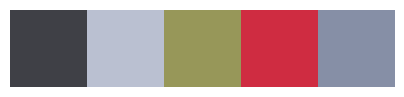

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,1))
plt.imshow([common_colors])
plt.axis('off')
plt.show()


In [ ]:
folder = 'kasbit_images/lagos fashion week/processed'
all_colors = []

for img_name in os.listdir(folder):
    if img_name.lower().endswith(('.jpg', '.png')):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pixels = img.reshape(-1, 3)
        color_fraction_list = extract_colors(img_path, n_colors=3)
        all_colors.append(pixels)

all_colors = np.vstack(all_colors)


overall_k = 5  # number of main colors for the collection
kmeans_all = KMeans(n_clusters=overall_k, random_state=42)
labels = kmeans_all.fit_predict(all_colors)  # weight by pixel fraction

dominant_colors = kmeans_all.cluster_centers_.astype(int)

# Calculate fraction of each dominant color
color_percentages = []

for i in range(overall_k):
    color_fraction = np.sum(labels == i) / len(labels)
    color_percentages.append(color_fraction * 100)

for color, perc in zip(dominant_colors, color_percentages):
    print(f"Color {color} appears in {perc:.2f}% of the collection")


Color [192 199 216] appears in 22.84% of the collection
Color [55 55 59] appears in 42.29% of the collection
Color [178  88  71] appears in 4.72% of the collection
Color [70 76 85] appears in 22.16% of the collection
Color [152 166 179] appears in 8.00% of the collection


In [30]:
# Optional: cluster all colors across images to find overall dominant colors
from sklearn.cluster import KMeans

kmeans_shape = KMeans(n_clusters=5, random_state=42)
#kmeans_shape.fit(silhouettes)
common_shapes = kmeans_shape.fit_predict(pca_results)

print("Most common silhouttes for brand:", common_shapes)


Most common silhouttes for brand: [2 2 1 1 1 3 3 1 1 4 0 0 2 2 2 3 2 2 1 1 1 3 3 1 1 4 0 0 2 2 2 3]


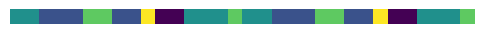

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,1))
plt.imshow([common_shapes])
plt.axis('off')
plt.show()

DEEPLABV3

In [33]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
from torchvision.transforms.functional import resize
import cv2
from sklearn.cluster import KMeans

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((520,520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset_dict = {"kasbit_images": ["bellanaija"]}
preprocessed_images = {}

for kasbit, folders in dataset_dict.items():
    kasbit_img = []

    for folder in folders:
        folder_dir = os.path.join(kasbit, folder)
        
        for img_name in os.listdir(folder_dir):
            img_path = os.path.join(folder_dir, img_name)
           
            if not img_name.lower().endswith(('.jpg','.jpeg', '.png')):
                continue
            
            if "segmented" in img_path:
                continue

            try:
                input_image = Image.open(img_path).convert("RGB")
                input_tensor = preprocess(input_image)
                kasbit_img.append(input_tensor)
            
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
                continue

    preprocessed_images[kasbit] = torch.stack(kasbit_img)
    print(f"Segmented {len(kasbit_img)} images for {kasbit}.\n")

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to C:\Users\User/.cache\torch\hub\checkpoints\deeplabv3_mobilenet_v3_large-fc3c493d.pth


100%|██████████| 42.3M/42.3M [00:04<00:00, 10.1MB/s]


Segmented 44 images for kasbit_images.



In [ ]:
COLOURS = {"Black": [0, 0, 0], "White": [100, 0, 0], "Gray": [50, 0, 0],
    "Red": [53, 80, 67], "Blue": [32, 79, -107], "Green": [87, -86, 83],
    "Navy": [12, 10, -35], "Beige": [85, 5, 20], "Burgundy": [25, 45, 15],
    "Olive": [45, -10, 30], "Pink": [85, 15, 5], "Yellow": [97, -21, 94]}

def get_colour_name(lab_pixel):
    

In [ ]:
model2 = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT')

model2.eval()

seg_outputs = {}
seg_masks = {}
garment_masks = {}
garment_img = {}
garment_lab = {}
garment_pixels_flat = {}
garment_colours = {}

with torch.no_grad():
    for kasbit, images in preprocessed_images.items():
        outputs = model2(images)['out']
        seg_outputs[kasbit] = outputs
        print(f"Segmentation completed for {kasbit}.\n")

for kasbit, outputs in seg_outputs.items():
    masks = torch.argmax(outputs, dim=1)
    seg_masks[kasbit] = masks
    print(f"Masks extracted for {kasbit}.\n")

for kasbit, masks in seg_masks.items():
    garment_masks[kasbit] = masks != 0

for kasbit, masks in garment_masks.items():
    masked_img = []
    lab_img = []
    flattened_pixels = []
    colour_list = []

    for i, mask in enumerate(masks):
        img_path = os.path.join(kasbit, dataset_dict[kasbit][0], os.listdir(os.path.join(kasbit, dataset_dict[kasbit][0]))[i])

        img = Image.open(img_path).convert("RGB")
        img = resize(img, mask.shape[-2:])
        img_np = np.array(img)

        mask_np = mask.cpu().numpy()
        masked = img_np * mask_np[:, :, None]
        masked_img.append(masked)

        img_lab = cv2.cvtColor(masked.astype(np.uint8), cv2.COLOR_RGB2LAB)
        lab_img.append(img_lab)
        
        pixels_flat = img_lab[mask_np]
        flattened_pixels.append(pixels_flat)

        if len(pixels_flat) > 0:
            n = 5
            kmeans = KMeans(n_clusters=n, random_state=42)
            kmeans.fit(pixels_flat)
            colour_list.append(kmeans.cluster_centers_)
        else:
            colour_list.append(np.zeros((n, 3)))

    garment_img[kasbit] = masked_img
    garment_lab[kasbit] = lab_img
    garment_pixels_flat[kasbit] = flattened_pixels
    garment_colours[kasbit] = colour_list

print("Garment images extracted and converted to LAB for all brands.")

Segmentation completed for kasbit_images.

Masks extracted for kasbit_images.

Garment images extracted and converted to LAB for all brands.
